Best Parameter
clf__alpha :  2
tfidf__min_df :  1
tfidf__stop_words :  None
best f1 score: 0.7134380001639543
Precision, Recall, F1-score, support
              precision    recall  f1-score   support

           1       0.74      0.76      0.75        99
           2       0.76      0.74      0.75       102

   micro avg       0.75      0.75      0.75       201
   macro avg       0.75      0.75      0.75       201
weighted avg       0.75      0.75      0.75       201

AUC score
0.835016835016835
Precision_Recall curve


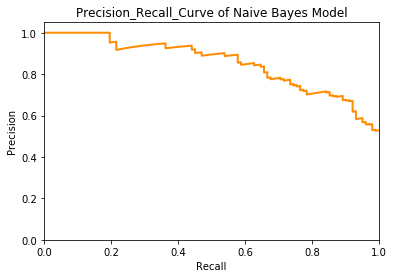

AUC curve


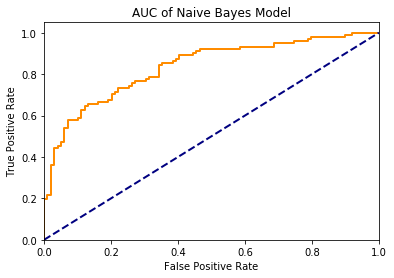

F1 SVM vs F1 NB
AUC SVM vs AUC NB


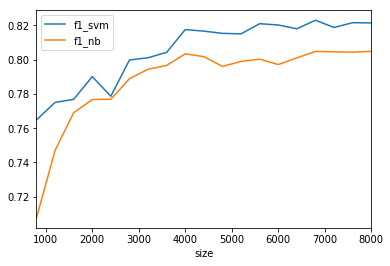

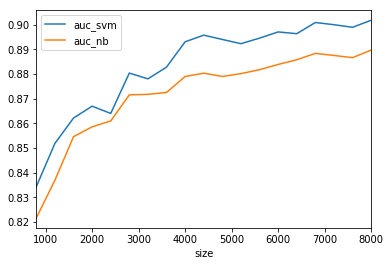

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
from termcolor import colored



def classify(train, test):
    #getting training and testing file
    data_train = pd.read_csv(train)
    data_test = pd.read_csv(test)
    
    #get best parameter
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                   ])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__alpha': [0.5, 1, 2],
    }

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)

    gs_clf = gs_clf.fit(data_train["text"], data_train["label"])
    
    #printing best parameter
    print(colored("Best Parameter", color="green", attrs=['bold']))
    for param_name in gs_clf.best_params_:
        print(param_name,": ",gs_clf.best_params_[param_name])
    #getting best f1 score
    print("best f1 score:", gs_clf.best_score_)
    
    
    #using those parameter to train model
    tfidf_vect = TfidfVectorizer(stop_words=gs_clf.best_params_['tfidf__stop_words'], min_df=gs_clf.best_params_['tfidf__min_df']) 

    dtm= tfidf_vect.fit_transform(data_train["text"])

    clf = MultinomialNB(alpha=gs_clf.best_params_['clf__alpha']).fit(dtm, data_train["label"])
    
    #getting precision, recall, f1_score, macro, 
    dtm_test=tfidf_vect.transform(data_test["text"])
    predicted=clf.predict(dtm_test)

    labels=sorted(data_train["label"].unique())
    print(colored("Precision, Recall, F1-score, support", color="green", attrs=['bold']))
    print(classification_report(data_test["label"], predicted, labels=labels))
    
    #gettin auc score
    predict_p=clf.predict_proba(dtm_test)
    binary_y = np.where(data_test["label"]==2,1,0)
    y_pred = predict_p[:,1]
    fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label=1)
    print(colored("AUC score", color="green", attrs=['bold']))
    print(auc(fpr, tpr))
    
    #plotting precision vs recall curve
    precision, recall, thresholds = precision_recall_curve(binary_y, \
                                y_pred, pos_label=1)

    plt.figure();
    plt.plot(recall, precision, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    print(colored("Precision_Recall curve", color="green", attrs=['bold']))
    plt.show();

    #plotting roc_auc curve
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    print(colored("AUC curve", color="green", attrs=['bold']))
    plt.show();
    
def impact_of_sample_size(train):
    
    data_large = pd.read_csv(train)
    results=[]
    size = []
    tfidf_vect = TfidfVectorizer(stop_words="english") 
    dtm = tfidf_vect.fit_transform(data_large["text"])
    metrics = ["f1_macro", "roc_auc"]

    clf1 = svm.LinearSVC()
    clf2 = MultinomialNB()

    labels=sorted(data_large["label"].unique())
    binary_y = np.where(data_large["label"]==2,1,0)
    
    r=800

    while r <= len(data_large):

        #svm
        cv1 = cross_validate(clf1, dtm[0:r], binary_y[0:r], scoring=metrics, cv=5, return_train_score=True)
        a1 = cv1['test_f1_macro']
        c1 = cv1['test_roc_auc']


        #binomial
        cv2 = cross_validate(clf2, dtm[0:r], binary_y[0:r], scoring=metrics, cv=5, return_train_score=True)
        a2 = cv2['test_f1_macro']
        c2 = cv2['test_roc_auc']
        results.append((r,np.mean(np.average(a1)),np.mean(np.average(a2)),np.mean(np.average(c1)),np.mean(np.average(c2))))
        r += 400

    results=pd.DataFrame(results, columns=["size","f1_svm","f1_nb","auc_svm","auc_nb"])
    results=results.set_index("size") 
    print(colored("F1 SVM vs F1 NB", color="green", attrs=['bold']))
    results[["f1_svm","f1_nb"]].plot(kind="line")

    print(colored("AUC SVM vs AUC NB", color="green", attrs=['bold']))
    results[["auc_svm","auc_nb"]].plot(kind="line")
    
    
classify("train.csv","test.csv")
impact_of_sample_size("train_large.csv")